<a href="https://colab.research.google.com/github/Kittipong-Dev/secondhand-pricing-model/blob/main/secondhand_pricing_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# download file
!wget https://github.com/NextGen-AI-Camp/curriculum-2025/releases/download/Workshop-Week2-Dataset/dataset.zip
!unzip dataset.zip

Streaming output truncated to the last 5000 lines.
  inflating: dataset/audio/1dbd1e95-7169-48ca-b4fa-415b3d1bbc16.wav  
  inflating: dataset/audio/1e1eb714-7f3f-4077-8658-c2128ee3c088.wav  
  inflating: dataset/audio/1e2e05b8-026a-4fd2-a423-e7fec81e9acd.wav  
  inflating: dataset/audio/1e38934e-3e6d-4e3b-a60b-bef5276d760d.wav  
  inflating: dataset/audio/1e5b41aa-68f3-4f35-a133-e2f0858194e9.wav  
  inflating: dataset/audio/1e6efe45-e082-444d-bf57-a5c71fa4d907.wav  
  inflating: dataset/audio/1eade6d3-ece9-40cf-92ff-60af3e7cd94d.wav  
  inflating: dataset/audio/1f23de8d-8a75-49a1-af06-be20ded95343.wav  
  inflating: dataset/audio/1f25d10a-9669-4fa0-a37c-fdc3934f22ed.wav  
  inflating: dataset/audio/1f85a831-7a63-4d57-8087-b2f92c4fd865.wav  
  inflating: dataset/audio/1faaa5ce-6908-41f2-a802-58e525bb596a.wav  
  inflating: dataset/audio/1fc05930-95bb-40de-9fe5-8205a75ffc35.wav  
  inflating: dataset/audio/1fd121cf-529e-4cb5-a488-c933bc87b9c4.wav  
  inflating: dataset/audio/200df4b2-30b

In [ ]:
# mount to google drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!cp /content/dataset/labeled_train.csv /content/drive/MyDrive/secondhand-evaluating-model/labeled_train.csv

In [ ]:
!cp /content/drive/MyDrive/secondhand-evaluating-model/labeled_train.csv /content/dataset/labeled_train.csv

In [ ]:
# import all dependencies
import torch
import torchvision.transforms as transforms
from torch.utils.data import Dataset
from torch.utils.data import DataLoader,SubsetRandomSampler
from tqdm import tqdm
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms.functional as TF

import seaborn as sns

import os
import random

import pandas as pd

import numpy as np
import shutil
import cv2
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import classification_report, precision_score, recall_score, f1_score

from glob import glob
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from PIL import Image

import librosa
import IPython.display as display

from sklearn.preprocessing import LabelEncoder


In [ ]:
# try using cuda
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


In [ ]:
def set_seed(seed: int = 42):
    os.environ["PYTHONHASHSEED"] = str(seed)           # for Python hash-based operations
    random.seed(seed)                                  # Python random
    np.random.seed(seed)                               # NumPy
    torch.manual_seed(seed)                            # PyTorch CPU
    torch.cuda.manual_seed(seed)                       # PyTorch CUDA for current GPU
    torch.cuda.manual_seed_all(seed)                   # PyTorch CUDA for all GPUs
    # Force CUDA to be deterministic: may slow down, but reproducible
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

# Call this at the very top:
set_seed(42)

# Labeling Test and Train dataset

In [ ]:
def wav_to_logmel(wav_path, sr=16000, n_fft=1024, hop_length=320, n_mels=128, fixed_frames=512):
    try:
        y, orig_sr = librosa.load(wav_path, sr=None)
        if orig_sr != sr:
            y = librosa.resample(y, orig_sr=orig_sr, target_sr=sr)
        y, _ = librosa.effects.trim(y)

        if len(y) == 0:
            raise ValueError("Empty audio after trimming")

        mel = librosa.feature.melspectrogram(
            y=y, sr=sr, n_fft=n_fft, hop_length=hop_length,
            n_mels=n_mels, power=2.0
        )
        logmel = librosa.power_to_db(mel, ref=np.max)
        logmel = np.clip(logmel, a_min=-80.0, a_max=None)

        # Pad or truncate to fixed_frames
        if logmel.shape[1] < fixed_frames:
            pad = fixed_frames - logmel.shape[1]
            logmel = np.pad(logmel, ((0, 0), (0, pad)), mode="constant")
        else:
            logmel = logmel[:, :fixed_frames]

        return logmel.astype(np.float32)
    except Exception as e:
        raise RuntimeError(f"Failed processing {wav_path}: {e}")

In [ ]:
class InferenceMelDataset(Dataset):
    def __init__(self, csv_path, audio_dir):
        self.df = pd.read_csv(csv_path)
        self.audio_dir = audio_dir

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        fname = row["image_file"].replace(".jpg", ".wav")
        wav_path = os.path.join(self.audio_dir, fname)
        logmel = wav_to_logmel(wav_path)  # [128, T]
        logmel_tensor = torch.tensor(logmel).unsqueeze(0)  # [1, 128, T]
        return logmel_tensor, row["image_file"]

In [ ]:
train_audio_dataset = InferenceMelDataset(
    csv_path="/content/dataset/train.csv",
    audio_dir="/content/dataset/audio"
)
train_audio_loader = DataLoader(train_audio_dataset, batch_size=16, shuffle=False)

In [ ]:
test_audio_dataset = InferenceMelDataset(
    csv_path="/content/dataset/test.csv",
    audio_dir="/content/dataset/audio"
)
test_audio_loader = DataLoader(test_audio_dataset, batch_size=16, shuffle=False)

In [ ]:
class BasicBlock(nn.Module):
    expansion = 1
    def __init__(self, in_planes, planes, stride=1):
        super().__init__()
        self.conv1 = nn.Conv2d(in_planes, planes, 3, stride, 1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, 3, 1, 1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != self.expansion * planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, self.expansion * planes, 1, stride, bias=False),
                nn.BatchNorm2d(self.expansion * planes)
            )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out)) + self.shortcut(x)
        return F.relu(out)


In [ ]:
class SecondhandAudioEvaluatingModel(nn.Module):
    def __init__(self):
        super().__init__()

        self.labels = ["smell", "pilling", "condition"]
        self.out_dims = [2, 5, 5]

        self.conv1 = nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)

        self.layer1_block1 = BasicBlock(64, 64, stride=1)
        self.layer1_block2 = BasicBlock(64, 64, stride=1)
        self.layer2_block1 = BasicBlock(64, 128, stride=2)
        self.layer2_block2 = BasicBlock(128, 128, stride=1)
        self.layer3_block1 = BasicBlock(128, 256, stride=2)
        self.layer3_block2 = BasicBlock(256, 256, stride=1)
        self.layer4_block1 = BasicBlock(256, 512, stride=2)
        self.layer4_block2 = BasicBlock(512, 512, stride=1)

        # Explicitly name heads for each task
        self.head_smell = nn.Linear(512, 2)
        self.head_pilling = nn.Linear(512, 5)
        self.head_condition = nn.Linear(512, 5)

    def forward(self, x):
        x = self.maxpool(F.relu(self.bn1(self.conv1(x))))
        x = self.layer1_block1(x); x = self.layer1_block2(x)
        x = self.layer2_block1(x); x = self.layer2_block2(x)
        x = self.layer3_block1(x); x = self.layer3_block2(x)
        x = self.layer4_block1(x); x = self.layer4_block2(x)
        x = F.adaptive_avg_pool2d(x, (1, 1)).view(x.size(0), -1)  # [B, 512]

        # Return dictionary without for loop
        return {
            "smell": self.head_smell(x),
            "pilling": self.head_pilling(x),
            "condition": self.head_condition(x)
        }

In [ ]:
class SecondhandImageEvaluatingModel(nn.Module):
  def __init__(self):
    super(SecondhandImageEvaluatingModel, self).__init__()
    self.labels = ["type", "color"]
    self.out_dims = [2, 11]  # type has 2 classes, color has 11

    self.conv1 = nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3, bias=False)
    self.bn1 = nn.BatchNorm2d(64)
    self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)

    self.layer1_block1 = BasicBlock(64, 64, stride=1)
    self.layer1_block2 = BasicBlock(64, 64, stride=1)
    self.layer2_block1 = BasicBlock(64, 128, stride=2)
    self.layer2_block2 = BasicBlock(128, 128, stride=1)
    self.layer3_block1 = BasicBlock(128, 256, stride=2)
    self.layer3_block2 = BasicBlock(256, 256, stride=1)
    self.layer4_block1 = BasicBlock(256, 512, stride=2)
    self.layer4_block2 = BasicBlock(512, 512, stride=1)
    self.type_out = nn.Linear(512 * BasicBlock.expansion, self.out_dims[0])
    self.color_out = nn.Linear(512 * BasicBlock.expansion, self.out_dims[1])

  def forward(self, x):
    out = self.maxpool(F.relu(self.bn1(self.conv1(x))))

    out = self.layer1_block1(out) #64
    out = self.layer1_block2(out)

    out = self.layer2_block1(out) #128
    out = self.layer2_block2(out)

    out = self.layer3_block1(out) #256
    out = self.layer3_block2(out)

    out = self.layer4_block1(out) #512
    out = self.layer4_block2(out)

    out = nn.AdaptiveAvgPool2d((1, 1))(out) # [32, 512, 7, 7] --> [32, 512, 1, 1]
    out = out.view(out.size(0), -1) # [32, 512]

    type_out, color_out = self.type_out(out), self.color_out(out)
    return {"type": type_out, "color": color_out}

In [ ]:
class SecondhandEvaluatingModel(nn.Module):
  def __init__(self, modelA=SecondhandAudioEvaluatingModel(), modelB=SecondhandImageEvaluatingModel(), task_keysA=["smell", "pilling", "condition"], task_keysB=["type", "color"]):
    super().__init__()
    self.modelA = modelA
    self.modelB = modelB
    self.task_keysA = task_keysA
    self.task_keysB = task_keysB
    self.out_dims = [modelA.out_dims[modelA.labels.index(k)] for k in task_keysA] + \
                    [modelB.out_dims[modelB.labels.index(k)] for k in task_keysB]

  def forward(self, xA, xB):
    outA = self.modelA(xA)
    outB = self.modelB(xB)
    out = {}
    for k in self.task_keysA:
        out[k] = outA[k]
    for k in self.task_keysB:
        out[k] = outB[k]
    return out

In [ ]:
class NoLabelImageDataset(Dataset):
    def __init__(self, df, image_folder, transform=None):
        self.df = df
        self.image_folder = image_folder
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        fname = self.df.iloc[idx]['image_file']
        path = os.path.join(self.image_folder, fname)
        image = Image.open(path).convert('RGB')
        if self.transform:
            image = self.transform(image)
        return image, fname

In [ ]:
transform = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.6554, 0.6678, 0.6761],
                         std=[0.1793, 0.1804, 0.1822])
])

In [ ]:
train_csv_path = "/content/dataset/train.csv"
test_csv_path = "/content/dataset/test.csv"
train_output_path = "/content/dataset/labeled_train.csv"
test_output_path = "/content/dataset/labeled_test.csv"
pth_path = "/content/drive/MyDrive/aice workshop1/combined_model.pth"
image_folder = "/content/dataset/image/"

In [ ]:
train_image_dataset = NoLabelImageDataset(pd.read_csv(train_csv_path), image_folder, transform=transform)
train_image_loader = DataLoader(train_image_dataset, batch_size=16, shuffle=False)

In [ ]:
test_image_dataset = NoLabelImageDataset(pd.read_csv(test_csv_path), image_folder, transform=transform)
test_image_loader = DataLoader(test_image_dataset, batch_size=16, shuffle=False)

In [ ]:
# model = SecondhandEvaluatingModel()
# model.load_state_dict(torch.load(pth_path))
# model.to(device)
# model.eval()

# df = pd.read_csv(csv_path)

# idx_to = {
#     "type": ['bottom', 'top'],
#     "color": ['Black', 'Blue', 'Brown', 'Gray', 'Green', 'Orange', 'Pink', 'Purple', 'Red', 'White', 'Yellow'],
#     "smell": ["FALSE",  "TRUE"],
#     "pilling": [str(i) for i in range(1, 6)],
#     "condition": [str(i) for i in range(1, 6)]
# }
# labels = ["type", "color", "smell", "pilling", "condition"]
# updates = []

# with torch.no_grad():
#   for (xB, filenames_img), (xA, filenames_audio) in tqdm(zip(image_loader, audio_loader), total=len(image_loader), desc="🔍 Running inference"):
#     # ✅ ตรวจสอบว่า filename ตรงกัน
#     assert list(filenames_img) == list(filenames_audio), "Mismatch between image and audio batches!"
#     xA = xA.to(device)  # audio
#     xB = xB.to(device)  # image

#     outputs = model(xA, xB)

#     batch_preds = {
#       label: outputs[label].argmax(dim=1).cpu().numpy()
#       for label in labels
#     }

#     for i, fname in enumerate(filenames_img):
#       record = {"image_file": fname}
#       for label in labels:
#         class_idx = batch_preds[label][i]
#         record[label] = idx_to[label][class_idx]
#       updates.append(record)

# updates_df = pd.DataFrame(updates).set_index("image_file")

# df = df.set_index("image_file")
# for col in labels:
#     df[col] = updates_df[col]

# df = df.reset_index()

# df.to_csv(output_path, index=False)
# print(f"Saved csv to {output_path}")

NameError: name 'SecondhandEvaluatingModel' is not defined

In [ ]:
def create_csv(model, pth_path, device, csv_path, image_loader, audio_loader, output_path):
  model.load_state_dict(torch.load(pth_path))
  model.to(device)
  model.eval()

  df = pd.read_csv(csv_path)

  idx_to = {
      "type": ['bottom', 'top'],
      "color": ['Black', 'Blue', 'Brown', 'Gray', 'Green', 'Orange', 'Pink', 'Purple', 'Red', 'White', 'Yellow'],
      "smell": ["FALSE",  "TRUE"],
      "pilling": [str(i) for i in range(1, 6)],
      "condition": [str(i) for i in range(1, 6)]
  }
  labels = ["type", "color", "smell", "pilling", "condition"]
  updates = []

  with torch.no_grad():
    for (xB, filenames_img), (xA, filenames_audio) in tqdm(zip(image_loader, audio_loader), total=len(image_loader), desc="🔍 Running inference"):
      # ✅ ตรวจสอบว่า filename ตรงกัน
      assert list(filenames_img) == list(filenames_audio), "Mismatch between image and audio batches!"
      xA = xA.to(device)  # audio
      xB = xB.to(device)  # image

      outputs = model(xA, xB)

      batch_preds = {
        label: outputs[label].argmax(dim=1).cpu().numpy()
        for label in labels
      }

      for i, fname in enumerate(filenames_img):
        record = {"image_file": fname}
        for label in labels:
          class_idx = batch_preds[label][i]
          record[label] = idx_to[label][class_idx]
        updates.append(record)

  updates_df = pd.DataFrame(updates).set_index("image_file")

  df = df.set_index("image_file")
  for col in labels:
      df[col] = updates_df[col]

  df = df.reset_index()

  df.to_csv(output_path, index=False)
  print(f"Saved csv to {output_path}")

In [ ]:
create_csv(SecondhandEvaluatingModel(),
           pth_path,
           device,
           train_csv_path,
           train_image_loader,
           train_audio_loader,
           train_output_path)

🔍 Running inference: 100%|██████████| 141/141 [01:44<00:00,  1.36it/s]

Saved csv to /content/dataset/labeled_train.csv


In [ ]:
create_csv(SecondhandEvaluatingModel(),
           pth_path,
           device,
           test_csv_path,
           test_image_loader,
           test_audio_loader,
           test_output_path)

🔍 Running inference: 100%|██████████| 25/25 [00:14<00:00,  1.70it/s]

Saved csv to /content/dataset/labeled_test.csv


In [ ]:
!cp /content/dataset/labeled_train.csv /content/drive/MyDrive/secondhand-evaluating-model/labeled_train.csv

In [ ]:
!cp /content/dataset/labeled_test.csv /content/drive/MyDrive/secondhand-evaluating-model/labeled_test.csv

In [ ]:
!cp /content/drive/MyDrive/secondhand-evaluating-model/labeled_train.csv /content/dataset/labeled_train.csv

In [ ]:
!cp /content/drive/MyDrive/secondhand-evaluating-model/labeled_train.csv /content/dataset/labeled_test.csv

# Exporing Datasets

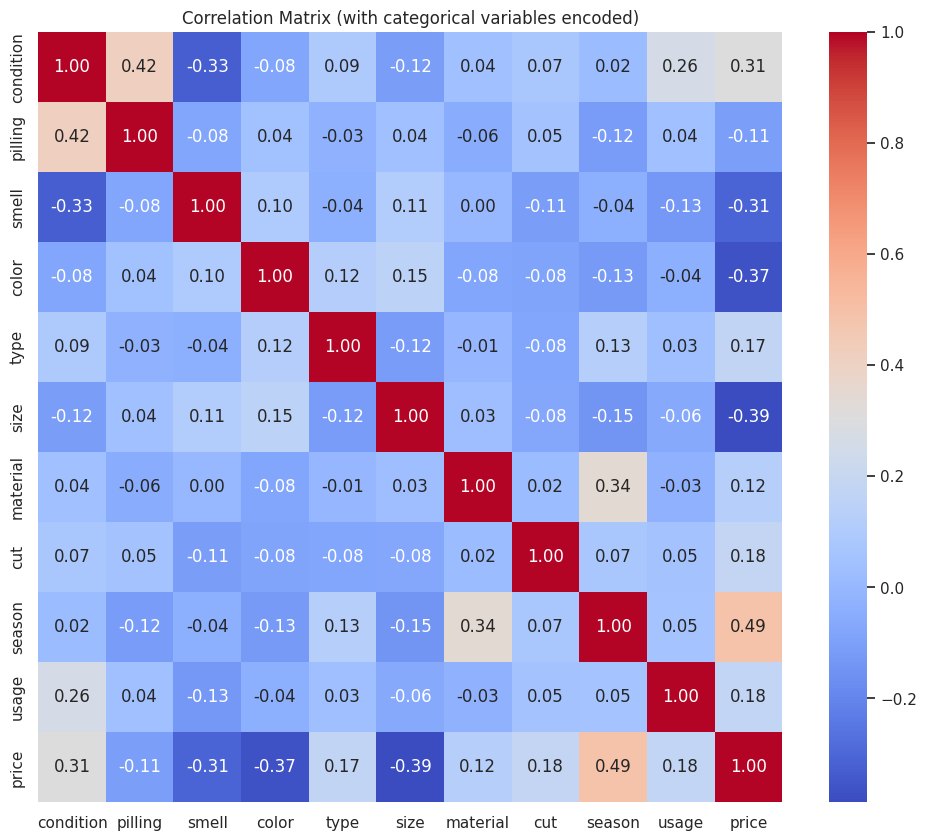

In [ ]:
df = pd.read_csv("/content/dataset/labeled_train.csv")

# Clone df to avoid modifying original
df_encoded = df.copy()
df_encoded.drop(columns="image_file", inplace=True)  # ✅ assign

# Columns that need encoding (categorical variables)
categorical_cols = ['smell', 'color', 'type', 'size', 'material', 'cut', 'season', 'usage']

# Apply Label Encoding
for col in categorical_cols:
    le = LabelEncoder()
    df_encoded[col] = le.fit_transform(df_encoded[col].astype(str))

# Now compute full correlation matrix
corr_matrix = df_encoded.corr()

# Display or visualize it
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 10))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Correlation Matrix (with categorical variables encoded)")
plt.show()


In [ ]:
len(df)

2253

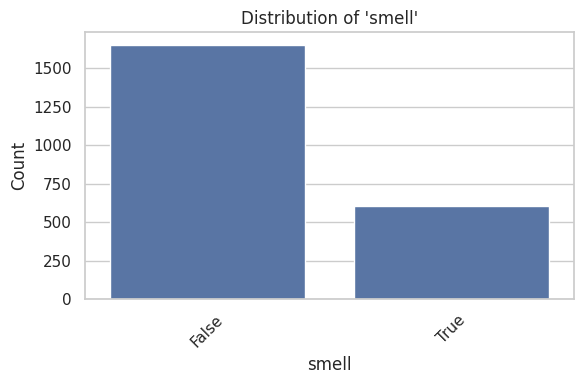

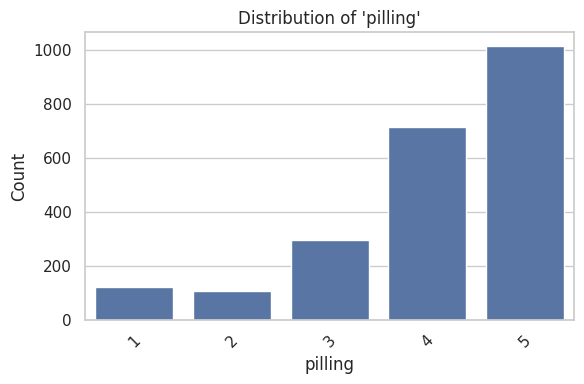

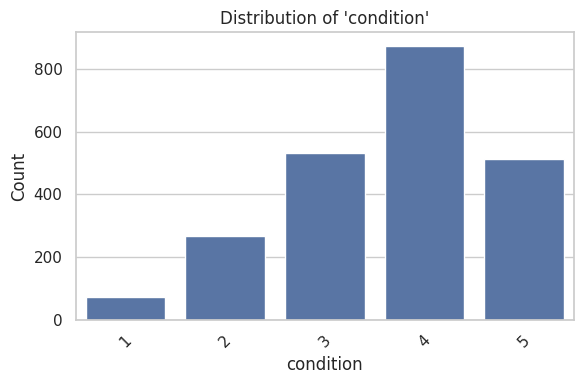

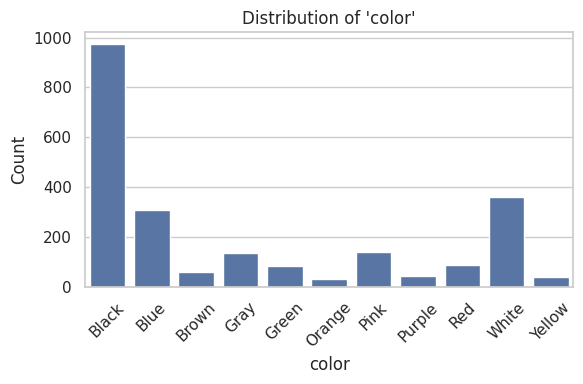

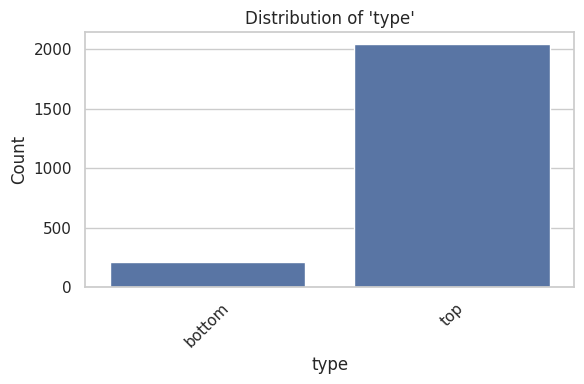

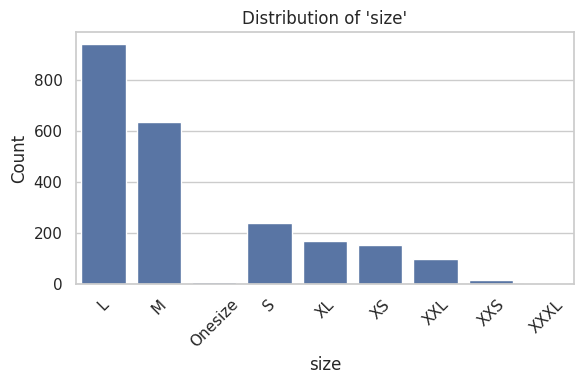

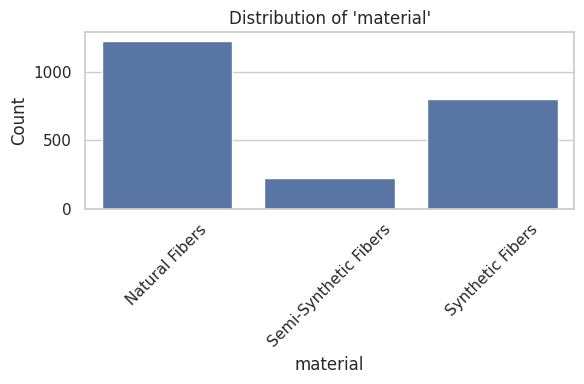

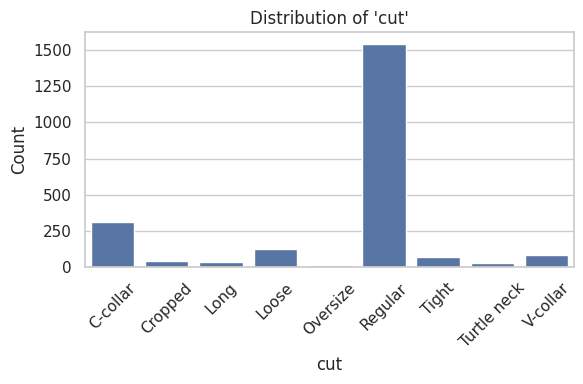

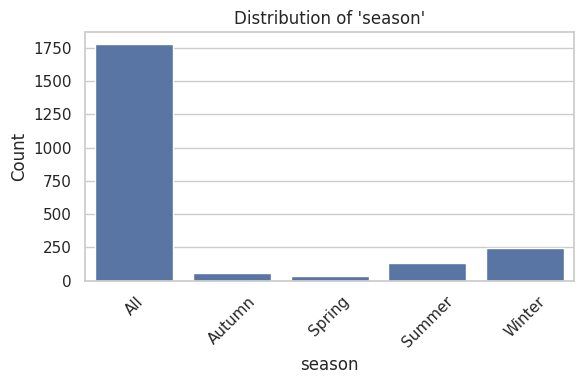

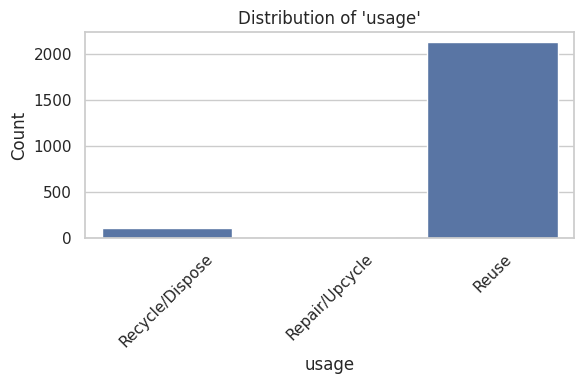

In [ ]:
# Set a nice theme
sns.set(style="whitegrid")

# Full list of categorical columns
categorical_columns = [
    'smell', 'pilling', 'condition', 'color', 'type',
    'size', 'material', 'cut', 'season', 'usage'
]

for col in categorical_columns:
    plt.figure(figsize=(6, 4))

    # Sort categories if possible
    try:
        order = sorted(df[col].unique())
    except:
        order = None

    sns.countplot(data=df, x=col, order=order)
    plt.title(f"Distribution of '{col}'")
    plt.xlabel(col)
    plt.ylabel("Count")
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()


พบ 71 outliers ในคอลัมน์ 'condition'


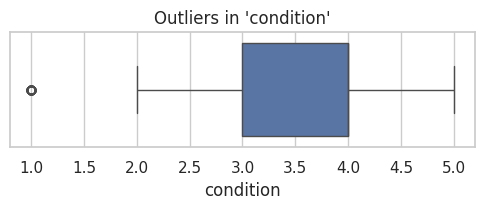

พบ 229 outliers ในคอลัมน์ 'pilling'


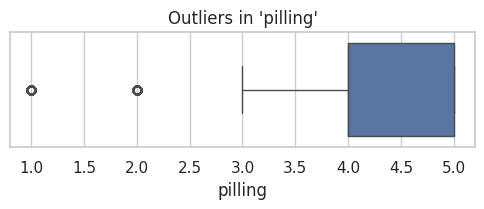

พบ 84 outliers ในคอลัมน์ 'price'


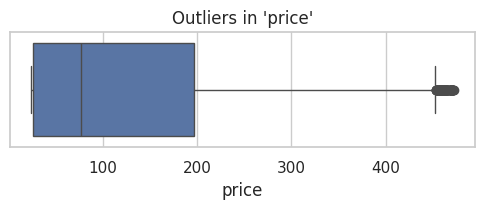

พบ 118 outliers ในคอลัมน์ 'outlier_flag'


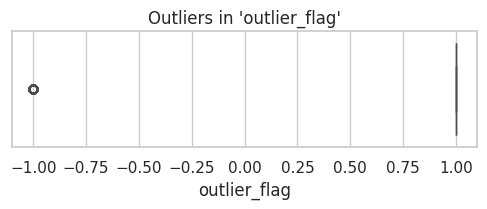

In [ ]:
def detect_outliers_iqr(df, column):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    outliers = df[(df[column] < lower_bound) | (df[column] > upper_bound)]
    return outliers

# ใช้กับทุกตัวแปรตัวเลข
numerical_cols = df.select_dtypes(include='number').columns

for col in numerical_cols:
    outliers = detect_outliers_iqr(df, col)
    print(f"พบ {len(outliers)} outliers ในคอลัมน์ '{col}'")

    # Boxplot แสดงภาพ
    plt.figure(figsize=(6, 1.5))
    sns.boxplot(x=df[col])
    plt.title(f"Outliers in '{col}'")
    plt.show()


In [ ]:
df = pd.read_csv("/content/dataset/labeled_train.csv")
columns = [
    'smell', 'pilling', 'condition', 'color', 'type',
    'size', 'material', 'cut', 'season', 'usage', 'price'
]
comb = 1
for col in columns:
  print(col, df[col].unique(), len(df[col].unique()))
  if col != "price":
    comb *= len(df[col].unique())
print(comb)

smell [ True False] 2
pilling [4 5 3 1 2] 5
condition [4 5 3 2 1] 5
color ['Pink' 'Purple' 'Brown' 'White' 'Orange' 'Green' 'Black' 'Red' 'Gray'
 'Blue' 'Yellow'] 11
type ['top' 'bottom'] 2
size ['L' 'XS' 'M' 'S' 'XXS' 'XL' 'XXL' 'Onesize' 'XXXL'] 9
material ['Natural Fibers' 'Synthetic Fibers' 'Semi-Synthetic Fibers'] 3
cut ['V-collar' 'Cropped' 'Regular' 'C-collar' 'Loose' 'Tight' 'Turtle neck'
 'Long' 'Oversize'] 9
season ['All' 'Summer' 'Winter' 'Autumn' 'Spring'] 5
usage ['Reuse' 'Recycle/Dispose' 'Repair/Upcycle'] 3
price [ 72.25  77.07  75.02 ... 335.79 338.14 309.89] 1537
4009500


In [ ]:
df.head()

,image_file,condition,pilling,smell,color,type,size,material,cut,season,usage,price
0,3d86e5f0-064d-4b3c-8cdf-148cf448e539.jpg,4,4,True,Pink,top,L,Natural Fibers,V-collar,All,Reuse,72.25
1,9f4a1503-96a8-48e7-aa58-d99d56e53067.jpg,5,5,True,Pink,top,XS,Synthetic Fibers,Cropped,Summer,Reuse,77.07
2,69341fad-0218-4dbf-92c9-8cf8a1605b5d.jpg,3,4,True,Purple,top,M,Semi-Synthetic Fibers,V-collar,All,Reuse,75.02
3,72071f20-b58d-4507-b180-a70342434819.jpg,4,5,False,Brown,top,S,Semi-Synthetic Fibers,V-collar,All,Reuse,122.78
4,fe886c74-a1fc-4701-ae21-6c862de83b5f.jpg,3,3,True,White,top,XS,Synthetic Fibers,Regular,Winter,Reuse,125.97


# Creating Model for Price Prediction

In [ ]:
import torch.nn as nn
import torch

class ResidualBlock(nn.Module):
    def __init__(self, dim):
        super().__init__()
        self.block = nn.Sequential(
            nn.Linear(dim, dim),
            nn.BatchNorm1d(dim),
            nn.ReLU(),
            nn.Linear(dim, dim),
            nn.BatchNorm1d(dim)
        )
        self.relu = nn.ReLU()

    def forward(self, x):
        return self.relu(self.block(x) + x)
class ResNetTabularModel(nn.Module):
    def __init__(self, input_dim, hidden_dim=128, num_blocks=3):
        super().__init__()
        self.input_layer = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.BatchNorm1d(hidden_dim),
            nn.ReLU()
        )

        self.res_blocks = nn.Sequential(
            *[ResidualBlock(hidden_dim) for _ in range(num_blocks)]
        )

        self.output_layer = nn.Linear(hidden_dim, 1)

    def forward(self, x):
        x = self.input_layer(x)
        x = self.res_blocks(x)
        return self.output_layer(x)


In [ ]:
# Load dataset
df = pd.read_csv(train_output_path)
# Convert True/False to 1/0
df["smell"] = df["smell"].astype(int)

# Shift condition and pilling from 1–5 to 0–4
df["condition"] = df["condition"] - 1
df["pilling"] = df["pilling"] - 1

# เลือกเฉพาะ columns ที่ใช้
feature_cols = ["condition", "pilling", "smell", "color", "type", "size", "material", "cut", "season", "usage"]
target_col = "price"
# from sklearn.preprocessing import StandardScaler
# scaler = StandardScaler()
# df["price_scaled"] = scaler.fit_transform(df["price"].values.reshape(-1, 1))

# Label encoding
encoders = {}
for col in feature_cols:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col])

# Train/test split
train_df, val_df = train_test_split(df, test_size=0.2, random_state=42)

In [ ]:
class TabularDataset(Dataset):
    def __init__(self, df, feature_cols, target_col):
        self.df = df
        self.feature_cols = feature_cols
        self.target_col = target_col

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        x = {col: torch.tensor(row[col], dtype=torch.long) for col in self.feature_cols}
        y = torch.tensor(row[self.target_col], dtype=torch.float32)
        return x, y

train_dataset = TabularDataset(train_df, feature_cols, target_col)
val_dataset = TabularDataset(val_df, feature_cols, target_col)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32)


In [ ]:
def exp_neg_mse(y_true, y_pred):
    """
    Exponential Negative Root Mean Squared Error
    Higher is better (max = 1)
    """
    mse = np.mean((y_true - y_pred) ** 2)
    return 1.5*np.exp(-5*1e-4*mse)


In [ ]:
def dict_to_tensor(x_dict):
    # input: {'condition': tensor([..]), 'pilling': tensor([..]), ...}
    # output: tensor([[condition_1, pilling_1, ..., usage_1],
    #                 [condition_2, pilling_2, ..., usage_2], ...])
    x_list = [x_dict[k].unsqueeze(1).float() for k in sorted(x_dict.keys())]
    x = torch.cat(x_list, dim=1)  # Shape: [batch_size, 10]
    return x


In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = ResNetTabularModel(10).to(device)
# model.load_state_dict(torch.load("price_regressor.pth"))

criterion = nn.MSELoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-3, weight_decay=1e-4)

# optimizer = torch.optim.SGD(model.parameters(), lr=1e-3)

def train_epoch(model, dataloader, optimizer, criterion):
    model.train()
    total_loss = 0
    y_true_all, y_pred_all = [], []
    for x_dict, y in dataloader:
        x_dict = {k: v.to(device) for k, v in x_dict.items()}
        x = dict_to_tensor(x_dict)  # [batch_size, 10] float tensor

        y = y.to(device).unsqueeze(1)

        optimizer.zero_grad()
        preds = model(x)
        loss = criterion(preds, y)
        loss.backward()
        optimizer.step()

        total_loss += loss.item() * len(y)

        y_true_all.extend(y.cpu().numpy())
        y_pred_all.extend(preds.detach().cpu().numpy())  # ✅ fixed

    score = exp_neg_mse(np.array(y_true_all), np.array(y_pred_all))
    return total_loss / len(dataloader.dataset), score

def evaluate_with_metric(model, dataloader, criterion):
    model.eval()
    total_loss = 0
    y_true_all, y_pred_all = [], []


    with torch.no_grad():
        for x_dict, y in dataloader:
            x_dict = {k: v.to(device) for k, v in x_dict.items()}
            y = y.to(device).unsqueeze(1)
            x = dict_to_tensor(x_dict)  # [batch_size, 10] float tensor

            preds = model(x)
            loss = criterion(preds, y)
            total_loss += loss.item() * len(y)

            y_true_all.extend(y.cpu().numpy())
            y_pred_all.extend(preds.cpu().numpy())

    avg_loss = total_loss / len(dataloader.dataset)
    score = exp_neg_mse(np.array(y_true_all), np.array(y_pred_all))
    return avg_loss, score


train_losses, train_scores, val_losses, val_scores = [], [], [], []

scheduler = None
# scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', factor=0.5, patience=5)

EPOCHS = 100

best_val_score = -float("inf")  # because higher is better for exp_neg_mse
best_model_path = "best_model.pth"

for epoch in range(1, EPOCHS + 1):
    train_loss, train_score = train_epoch(model, train_loader, optimizer, criterion)
    val_loss, val_score = evaluate_with_metric(model, val_loader, criterion)

    train_losses.append(train_loss)
    train_scores.append(train_score)
    val_losses.append(val_loss)
    val_scores.append(val_score)
    if (scheduler != None):
      scheduler.step(val_loss)

    if val_score > best_val_score:
        best_val_score = val_score
        torch.save(model.state_dict(), best_model_path)
        print(f"✅ New best model saved at epoch {epoch} with Val EN-MSE Score: {val_score:.4f}")

    print(f"[Epoch {epoch}] Train Loss: {train_loss:.4f} | Train EN-MSE Score: {train_score:.4f} | Val Loss: {val_loss:.4f} | Val EN-MSE Score: {val_score:.4f}")

✅ New best model saved at epoch 1 with Val EN-MSE Score: 0.0000
[Epoch 1] Train Loss: 31757.2235 | Train EN-MSE Score: 0.0000 | Val Loss: 26276.7496 | Val EN-MSE Score: 0.0000
✅ New best model saved at epoch 2 with Val EN-MSE Score: 0.0001
[Epoch 2] Train Loss: 25875.9950 | Train EN-MSE Score: 0.0000 | Val Loss: 20541.9331 | Val EN-MSE Score: 0.0001
✅ New best model saved at epoch 3 with Val EN-MSE Score: 0.0017
[Epoch 3] Train Loss: 18876.3712 | Train EN-MSE Score: 0.0001 | Val Loss: 13531.4456 | Val EN-MSE Score: 0.0017
✅ New best model saved at epoch 4 with Val EN-MSE Score: 0.0149
[Epoch 4] Train Loss: 12720.0723 | Train EN-MSE Score: 0.0026 | Val Loss: 9221.4918 | Val EN-MSE Score: 0.0149
✅ New best model saved at epoch 5 with Val EN-MSE Score: 0.1092
[Epoch 5] Train Loss: 8546.7924 | Train EN-MSE Score: 0.0209 | Val Loss: 5240.7765 | Val EN-MSE Score: 0.1092
✅ New best model saved at epoch 6 with Val EN-MSE Score: 0.1623
[Epoch 6] Train Loss: 6520.4442 | Train EN-MSE Score: 0.057

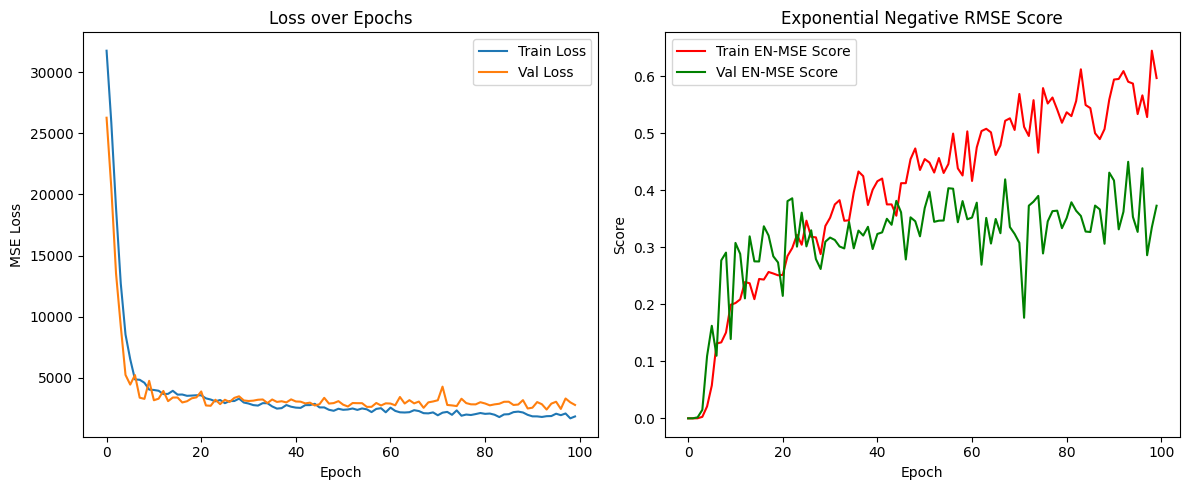

In [ ]:
plt.figure(figsize=(12, 5))

# Loss Graph
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Val Loss')
plt.title("Loss over Epochs")
plt.xlabel("Epoch")
plt.ylabel("MSE Loss")
plt.legend()

# Metric Graph
plt.subplot(1, 2, 2)
plt.plot(train_scores, color='red', label='Train EN-MSE Score')
plt.plot(val_scores, color='green', label='Val EN-MSE Score')
plt.title("Exponential Negative RMSE Score")
plt.xlabel("Epoch")
plt.ylabel("Score")
plt.legend()

plt.tight_layout()
plt.show()


In [ ]:
import numpy as np
import torch
from torch.utils.data import DataLoader
from sklearn.model_selection import KFold

# number of folds
NFOLDS = 5
kf = KFold(n_splits=NFOLDS, shuffle=True, random_state=42)

oof_scores = []

for fold, (train_idx, val_idx) in enumerate(kf.split(train_df), 1):
    print(f"\n=== Fold {fold}/{NFOLDS} ===")
    # split DataFrame
    df_tr = train_df.iloc[train_idx].reset_index(drop=True)
    df_val = train_df.iloc[val_idx].reset_index(drop=True)

    # create datasets & loaders
    tr_ds  = TabularDataset(df_tr,  feature_cols, target_col)
    val_ds = TabularDataset(df_val, feature_cols, target_col)
    tr_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, drop_last=True)
    val_loader = DataLoader(val_ds, batch_size=32, shuffle=False, num_workers=2)

    # fresh model, optimizer, scheduler
    model = ResNetTabularModel(len(feature_cols)).to(device)
    optimizer = torch.optim.AdamW(model.parameters(), lr=1e-3, weight_decay=1e-4)
    # scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', factor=0.5, patience=5)

    best_val_score = -float("inf")
    best_path = f"best_model_fold{fold}.pth"

    for epoch in range(1, EPOCHS+1):
        tr_loss, tr_score = train_epoch(model, tr_loader, optimizer, criterion)
        val_loss, val_score = evaluate_with_metric(model, val_loader, criterion)
        # if scheduler: scheduler.step(val_loss)

        if val_score > best_val_score:
            best_val_score = val_score
            torch.save(model.state_dict(), best_path)
            print(f"  → New best at epoch {epoch}: EN-MSE={val_score:.4f}")

        if epoch % 10 == 0:
            print(f"  [E{epoch:03d}] tr_loss={tr_loss:.1f}, tr_EN-MSE={tr_score:.4f} | "
                  f"val_loss={val_loss:.1f}, val_EN-MSE={val_score:.4f}")

    oof_scores.append(best_val_score)
    print(f"Fold {fold} best EN-MSE: {best_val_score:.4f}")

print("\n>>> CV results:")
for i, s in enumerate(oof_scores, 1):
    print(f"  Fold {i}: {s:.4f}")
print(f"  Mean EN-MSE: {np.mean(oof_scores):.4f}, Std: {np.std(oof_scores):.4f}")



=== Fold 1/5 ===
  → New best at epoch 1: EN-MSE=0.0000
  → New best at epoch 2: EN-MSE=0.0001
  → New best at epoch 3: EN-MSE=0.0009
  → New best at epoch 4: EN-MSE=0.0159
  → New best at epoch 5: EN-MSE=0.1432
  → New best at epoch 6: EN-MSE=0.1550
  → New best at epoch 7: EN-MSE=0.2757
  → New best at epoch 8: EN-MSE=0.2918
  → New best at epoch 9: EN-MSE=0.4255
  [E010] tr_loss=4401.4, tr_EN-MSE=0.1641 | val_loss=3083.6, val_EN-MSE=0.3210
  → New best at epoch 16: EN-MSE=0.4761
  → New best at epoch 19: EN-MSE=0.4871
  → New best at epoch 20: EN-MSE=0.5124
  [E020] tr_loss=3443.0, tr_EN-MSE=0.2656 | val_loss=2148.1, val_EN-MSE=0.5124
  → New best at epoch 22: EN-MSE=0.5195
  → New best at epoch 24: EN-MSE=0.5354
  [E030] tr_loss=3311.5, tr_EN-MSE=0.2838 | val_loss=2391.1, val_EN-MSE=0.4538
  → New best at epoch 36: EN-MSE=0.5546
  → New best at epoch 38: EN-MSE=0.6050
  [E040] tr_loss=2860.4, tr_EN-MSE=0.3560 | val_loss=1876.9, val_EN-MSE=0.5868
  → New best at epoch 49: EN-MSE=0.

In [ ]:
import torch
import torch.nn as nn

# จำนวน class ของแต่ละ feature (label encoded 0-indexed)
class_sizes = {
    "condition": 5,  # 1–5
    "pilling": 5,    # 1–5
    "smell": 2,      # TRUE/FALSE
    "color": 11,     # เช่น Black, White, ...
    "type": 2,       # bottom/top
    "size": 9,
    "material": 3,
    "cut": 9,
    "season": 5,
    "usage": 3,
}

# ขนาด embedding ของแต่ละ feature
embedding_dims = {
    'condition': 3,  # (5+1)//2 = 3
    'pilling': 3,    # (5+1)//2 = 3
    'smell': 1,      # (2+1)//2 = 1
    'color': 6,      # (11+1)//2 = 6
    'type': 1,       # (2+1)//2 = 1
    'size': 5,       # (9+1)//2 = 5
    'material': 2,   # (3+1)//2 = 2
    'cut': 5,        # (9+1)//2 = 5
    'season': 3,     # (5+1)//2 = 3
    'usage': 2       # (3+1)//2 = 2
}

class PriceRegressionModel(nn.Module):
    def __init__(self, class_sizes, embedding_dims):
        super().__init__()
        self.class_keys = list(class_sizes.keys())

        # ใช้ prefix "emb_" เพื่อหลีกเลี่ยงชื่อที่ชนกับ attribute
        self.embeddings = nn.ModuleDict({
            f"emb_{key}": nn.Embedding(num_embeddings=class_sizes[key], embedding_dim=embedding_dims[key])
            for key in self.class_keys
        })

        total_input_dim = sum(embedding_dims.values())
        self.regressor = nn.Sequential(
            nn.Linear(total_input_dim, 64),
            nn.ReLU(),
            nn.BatchNorm1d(64),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.BatchNorm1d(32),
            nn.Linear(32, 1)  # ราคาที่คาดการณ์
        )

    def forward(self, x_dict):
        # x_dict: dictionary of {feature_name: tensor of shape [B]}
        embedded = [self.embeddings[f"emb_{key}"](x_dict[key]) for key in self.class_keys]
        x = torch.cat(embedded, dim=1)
        return self.regressor(x)

In [ ]:
# ตรวจสอบ max ของแต่ละ column
for col in feature_cols:
    print(f"{col}: min = {df[col].min()}, max = {df[col].max()}, classes = {df[col].nunique()}")


condition: min = 0, max = 4, classes = 5
pilling: min = 0, max = 4, classes = 5
smell: min = 0, max = 1, classes = 2
color: min = 0, max = 10, classes = 11
type: min = 0, max = 1, classes = 2
size: min = 0, max = 8, classes = 9
material: min = 0, max = 2, classes = 3
cut: min = 0, max = 8, classes = 9
season: min = 0, max = 4, classes = 5
usage: min = 0, max = 2, classes = 3


In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# 1. แทนที่ class_sizes ด้วย:
class_sizes = {col: df[col].max() + 1 for col in feature_cols}

# 2. คำนวณ embedding dim ใหม่
embedding_dims = {key: min(50, (val + 1) // 2) for key, val in class_sizes.items()}

# 3. แล้วใช้ทั้งคู่ในการสร้าง model:
model = PriceRegressionModel(class_sizes, embedding_dims).to(device)
# model.load_state_dict(torch.load("price_regressor.pth"))

criterion = nn.MSELoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-3, weight_decay=1e-4)

def train_epoch(model, dataloader, optimizer, criterion):
    model.train()
    total_loss = 0
    for x_dict, y in dataloader:
        x_dict = {k: v.to(device) for k, v in x_dict.items()}
        y = y.to(device).unsqueeze(1)

        optimizer.zero_grad()
        preds = model(x_dict)
        loss = criterion(preds, y)
        loss.backward()
        optimizer.step()

        total_loss += loss.item() * len(y)

    return total_loss / len(dataloader.dataset)

def evaluate(model, dataloader, criterion):
    model.eval()
    total_loss = 0
    with torch.no_grad():
        for x_dict, y in dataloader:
            x_dict = {k: v.to(device) for k, v in x_dict.items()}
            y = y.to(device).unsqueeze(1)

            preds = model(x_dict)
            loss = criterion(preds, y)
            total_loss += loss.item() * len(y)

    return total_loss / len(dataloader.dataset)

def evaluate_with_metric(model, dataloader, criterion):
    model.eval()
    total_loss = 0
    y_true_all, y_pred_all = [], []

    with torch.no_grad():
        for x_dict, y in dataloader:
            x_dict = {k: v.to(device) for k, v in x_dict.items()}
            y = y.to(device).unsqueeze(1)

            preds = model(x_dict)
            loss = criterion(preds, y)
            total_loss += loss.item() * len(y)

            y_true_all.extend(y.cpu().numpy())
            y_pred_all.extend(preds.cpu().numpy())

    avg_loss = total_loss / len(dataloader.dataset)
    score = exp_neg_rmse(np.array(y_true_all), np.array(y_pred_all))
    return avg_loss, score


train_losses, val_losses, val_scores = [], [], []

scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', factor=0.5, patience=5)

EPOCHS = 40

for epoch in range(1, EPOCHS + 1):
    train_loss = train_epoch(model, train_loader, optimizer, criterion)
    val_loss, val_score = evaluate_with_metric(model, val_loader, criterion)

    train_losses.append(train_loss)
    val_losses.append(val_loss)
    val_scores.append(val_score)
    scheduler.step(val_loss)

    print(f"[Epoch {epoch}] Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f} | EN-RMSE Score: {val_score:.4f}")


[Epoch 1] Train Loss: 1925.7437 | Val Loss: 2626.9100 | EN-RMSE Score: 0.4033
[Epoch 2] Train Loss: 2084.2398 | Val Loss: 2356.1828 | EN-RMSE Score: 0.4618
[Epoch 3] Train Loss: 1836.4518 | Val Loss: 2973.2965 | EN-RMSE Score: 0.3392
[Epoch 4] Train Loss: 2305.4711 | Val Loss: 2548.3239 | EN-RMSE Score: 0.4195
[Epoch 5] Train Loss: 2114.8411 | Val Loss: 2565.1548 | EN-RMSE Score: 0.4160
[Epoch 6] Train Loss: 2282.8383 | Val Loss: 2940.0541 | EN-RMSE Score: 0.3449
[Epoch 7] Train Loss: 1888.8551 | Val Loss: 2569.3953 | EN-RMSE Score: 0.4151
[Epoch 8] Train Loss: 2040.9137 | Val Loss: 2555.5446 | EN-RMSE Score: 0.4180
[Epoch 9] Train Loss: 2187.2445 | Val Loss: 2400.3829 | EN-RMSE Score: 0.4517
[Epoch 10] Train Loss: 1879.9679 | Val Loss: 2453.5574 | EN-RMSE Score: 0.4399
[Epoch 11] Train Loss: 1917.8147 | Val Loss: 2375.3946 | EN-RMSE Score: 0.4574
[Epoch 12] Train Loss: 1891.1741 | Val Loss: 2449.1069 | EN-RMSE Score: 0.4408
[Epoch 13] Train Loss: 1803.1816 | Val Loss: 2531.6659 | EN-R

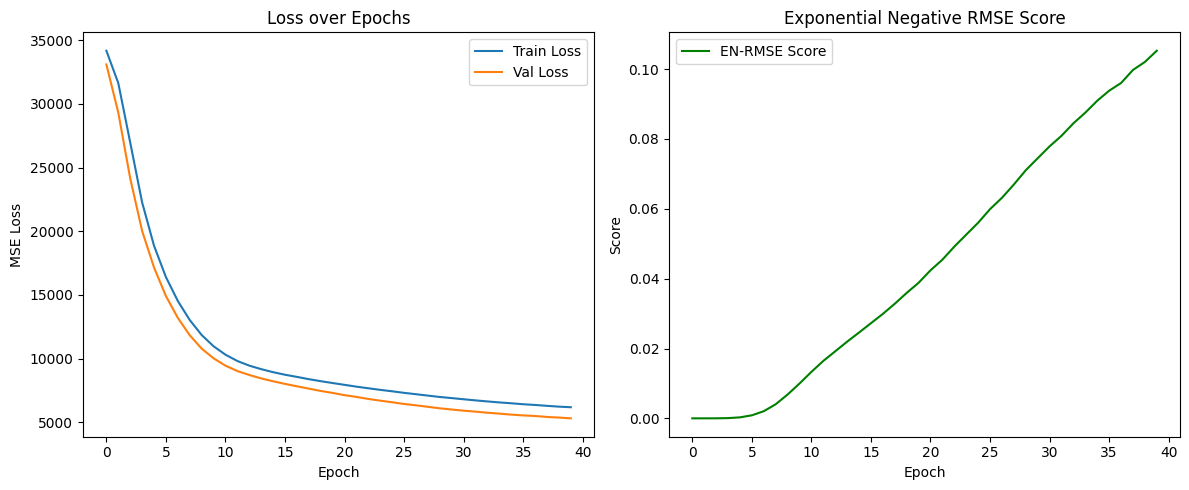

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 5))

# Loss Graph
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Val Loss')
plt.title("Loss over Epochs")
plt.xlabel("Epoch")
plt.ylabel("MSE Loss")
plt.legend()

# Metric Graph
plt.subplot(1, 2, 2)
plt.plot(val_scores, color='red', label='Train EN-MSE Score')
plt.plot(val_scores, color='green', label='Val EN-MSE Score')
plt.title("Exponential Negative RMSE Score")
plt.xlabel("Epoch")
plt.ylabel("Score")
plt.legend()

plt.tight_layout()
plt.show()


In [ ]:
# torch.save(model.state_dict(), "price_regressor.pth")

# Creating submission.csv

In [ ]:
df = pd.read_csv(test_output_path)
# Convert True/False to 1/0
df["smell"] = df["smell"].astype(int)

# Shift condition and pilling from 1–5 to 0–4
df["condition"] = df["condition"] - 1
df["pilling"] = df["pilling"] - 1

# เลือกเฉพาะ columns ที่ใช้
feature_cols = ["condition", "pilling", "smell", "color", "type", "size", "material", "cut", "season", "usage"]
target_col = "price"

# Label encoding
encoders = {}
for col in feature_cols:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col])

# Train/test split
test_df = df

In [ ]:
class TabularDataset(Dataset):
    def __init__(self, df, feature_cols, target_col):
        self.df = df
        self.feature_cols = feature_cols
        self.target_col = target_col

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        x = {col: torch.tensor(row[col], dtype=torch.long) for col in self.feature_cols}
        if self.target_col is not None:
            y = torch.tensor(row[self.target_col], dtype=torch.float32)
        else:
            y = torch.tensor(0.0)  # dummy for test set
        fname = row["image_file"]
        return x, y, fname

test_dataset = TabularDataset(test_df, feature_cols, target_col)

test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [ ]:
model = ResNetTabularModel(10)  # make sure this matches your trained model class
model_checkpoint = "/content/best_model_fold4.pth"   # or your checkpoint path
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model.load_state_dict(torch.load(model_checkpoint, map_location=device))
model.to(device)
model.eval()

# ==== Inference ====
pred_prices = []
image_files = []  # store filenames if needed

with torch.no_grad():
    for x_dict, y, fname in tqdm(test_loader):  # assuming test_loader yields (x_dict, y, fname)
        x_dict = {k: v.to(device) for k, v in x_dict.items()}
        preds = model(dict_to_tensor(x_dict))  # dict_to_tensor should convert to [batch_size, 10] tensor

        for i in range(len(preds)):
            pred_prices.append(preds[i].item())
            image_files.append(fname[i])  # fname should be a list of filenames

# ==== Save to new file ====
submission_df = pd.DataFrame({
    "image_file": image_files,
    "price": pred_prices
})

submission_path = "submission4.csv"
submission_df.to_csv(submission_path, index=False)
print(f"✅ Done! Results saved to {submission_path}")


100%|██████████| 13/13 [00:00<00:00, 156.93it/s]

✅ Done! Results saved to submission5.csv


In [ ]:
!mv -- *.pth *.csv /content/drive/MyDrive/secondhand-evaluating-model/save